# 画图：观察不同BatchSize

In [2]:
data = '''BS	1	2	3	4	5	6	7	8
MIA	0.8121	0.7329	0.6926	0.6772	0.6251	0.6102	0.6329	0.5679
TAG	0.9398	0.6825	0.5911	0.5369	0.5127	0.4672	0.4656	0.4414
SIP	0.9457	0.9607	0.9383	0.9485	0.9461	0.9487	0.9548	0.9458
BiSR (b)	0.9853	0.9709	0.9616	0.9607	0.9613	0.9624	0.965	0.9563
BiSR (f)	0.9901	0.9662	0.936	0.9346	0.9115	0.9	0.884	0.8855
BiSR (b+f)	0.9982	0.9698	0.9371	0.942	0.9157	0.9047	0.8892	0.8895'''

In [3]:
rows = data.split('\n')
rows = [row.split('\t') for row in rows if row]
rows = {row[0]: [float(f) for f in row[1:]] for row in rows}
rows['BS']= [int(f) for f in rows['BS']]

In [25]:

bs = rows['BS']
rgs_dra = rows['SIP']
rgs_tag = rows['TAG']
rgs_ours = rows['BiSR (b+f)']
rgs_fwd = rows['BiSR (f)']
rgs_bwd = rows['BiSR (b)']
rgs_mia = rows['MIA']

all_data = {'SIP-only':rgs_dra, 'TAG*':rgs_tag, 'BiSR (b+f)':rgs_ours,'BiSR (f)':rgs_fwd, 'BiSR (b)':rgs_bwd, 'MIA*':rgs_mia}

In [26]:
all_data

{'SIP-only': [0.9457, 0.9607, 0.9383, 0.9485, 0.9461, 0.9487, 0.9548, 0.9458],
 'TAG*': [0.9398, 0.6825, 0.5911, 0.5369, 0.5127, 0.4672, 0.4656, 0.4414],
 'BiSR (b+f)': [0.9982, 0.9698, 0.9371, 0.942, 0.9157, 0.9047, 0.8892, 0.8895],
 'BiSR (f)': [0.9901, 0.9662, 0.936, 0.9346, 0.9115, 0.9, 0.884, 0.8855],
 'BiSR (b)': [0.9853, 0.9709, 0.9616, 0.9607, 0.9613, 0.9624, 0.965, 0.9563],
 'MIA*': [0.8121, 0.7329, 0.6926, 0.6772, 0.6251, 0.6102, 0.6329, 0.5679]}

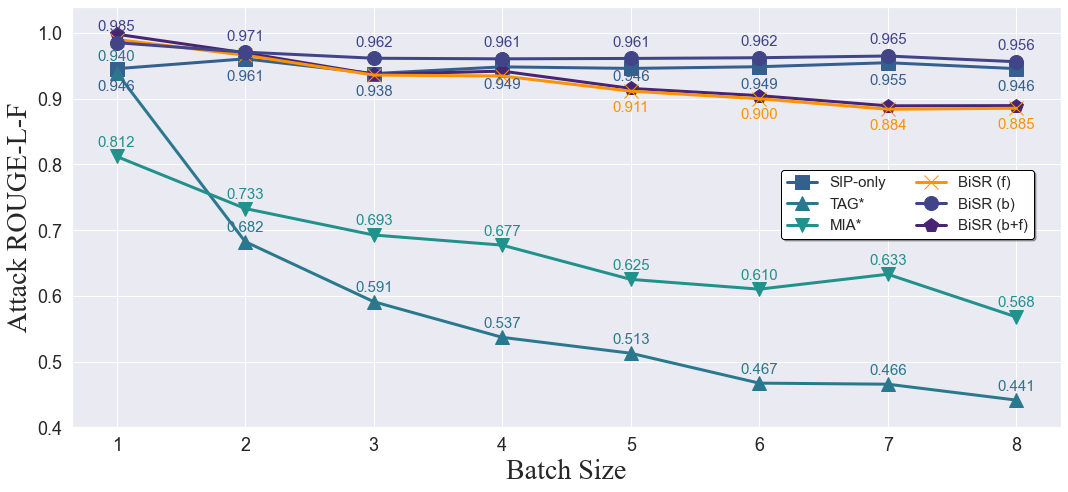

In [62]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
fig,ax = plt.subplots(figsize=(15,7))
atk_colors = sns.color_palette("viridis", 9)
color_ppl = sns.color_palette("autumn", 6)[3]
colors = {'BiSR (b)': atk_colors[1], 'SIP-only': atk_colors[2], 'TAG*': atk_colors[3],
            'MIA*': atk_colors[4], 'BiSR (b+f)': atk_colors[0], 'BiSR (f)': color_ppl}
marker_dict = {'BiSR (b)': 'o', 'SIP-only': 's', 'TAG*': '^','Test-PPL':'d',
            'MIA*': 'v', 'BiSR (b+f)': 'p', 'BiSR (f)': 'x'}
for name, rouges in all_data.items():
    ax.plot(bs, rouges, color=colors[name], label=name, marker=marker_dict[name],markersize=14,linewidth=3)


    for b, txt in zip(bs, rouges):
        if 'f' in name and not(name == 'BiSR (f)' and b >= 5):
                continue
        pos = 10
        if name == 'SIP-only':
            pos = -22
            if b == 5:
                pos = -12
        elif name == 'BiSR (b)':
            pos = 12
        elif name == 'BiSR (f)':
            pos = -20
        elif name == 'TAG*' and b == 1:
            pos = 12
        ax.annotate(f'{txt:.3f}', (b, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=colors[name],)

ax.set_ylabel('Attack ROUGE-L-F',  fontsize=28, fontname="Times New Roman")
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('Batch Size',  fontsize=28, fontname="Times New Roman")
ax.tick_params(axis='x', labelsize=18)
ax.set_ylim(0.4, 1.04)

handles, labels = ax.get_legend_handles_labels()
handles[2], handles[-1] = handles[-1], handles[2]
labels[2], labels[-1] = labels[-1], labels[2]
plt.legend(handles, labels,  loc='lower right', bbox_to_anchor=(0.98, 0.43), ncol=2, fontsize=15, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor='black',facecolor='white')
# plt.legend(fontsize=12, ncol=2, loc='lower right', bbox_to_anchor=(0.98, 0.43),
#            markerscale=0.9, handlelength=3.0)

plt.tight_layout()
plt.savefig('./diff_batch_size.pdf')